# Dati cumulativi

> Max Pierini

I dati grezzi sono 

- filtrati con _Hampel filter_, finestra gaussiana di 7 giorni, $\sigma=2$ per isolare gli outliers dal trend
- smussati con media mobile, finestra gaussiana di 14 giorni, $\sigma=5$ per evidenziare il trend

In [1]:
import json
import requests
import datetime as dt

from IPython.display import display, Math, Latex, Image, HTML, Markdown

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
import matplotlib.ticker as mtick

from scipy.optimize import curve_fit, brentq
from scipy import stats as sps
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

***

Modello **(S)IRD**

![compartments](https://maxpierini.it/ncov/pics/DATI-sito.png)

In [2]:
italy = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
italy = pd.read_csv(
    url,
    usecols=[
        'data', 
        'totale_casi', 'totale_positivi',
        'nuovi_positivi', 'variazione_totale_positivi',
        'deceduti', 'dimessi_guariti',
        'isolamento_domiciliare', 'ricoverati_con_sintomi', 'terapia_intensiva'
    ],
    parse_dates=['data'],
    index_col=['data'],
    squeeze=True).sort_index()

In [3]:
_ = """print(f"FIRST ENTRY DATE: {italy.index[0]}")

print(f"LAST  ENTRY DATE: {italy.index[-1]}")

period = (
    italy.index[-1] -
    italy.index[0]
).days

print("COVERAGE: {} days".format(period))

print("CURRENT DATE IS:  {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))"""

***

# Italia

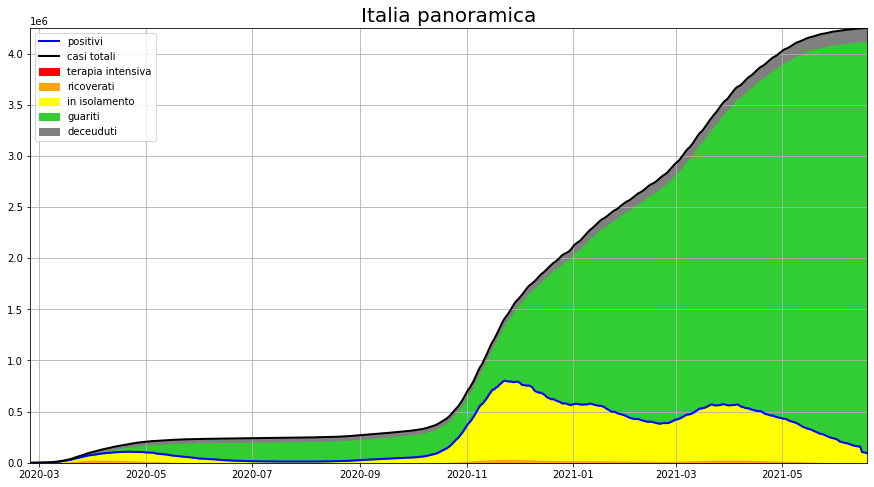

In [4]:
fig, ax = plt.subplots(figsize=(15, 8))

lo = 0
hi = italy['terapia_intensiva']
ax.fill_between(italy.index, lo, hi, color='red', label='terapia intensiva')

lo = italy['terapia_intensiva']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi']
ax.fill_between(italy.index, lo, hi, color='orange', label='ricoverati')

lo = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare']
ax.fill_between(italy.index, lo, hi, color='yellow', label='in isolamento')

ax.plot(italy.index, hi, 'b', label='positivi', lw=2)

lo = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare'] + italy['dimessi_guariti']
ax.fill_between(italy.index, lo, hi, color='limegreen', label='guariti')

lo = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare'] + italy['dimessi_guariti']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare'] + italy['dimessi_guariti'] + italy['deceduti']
ax.fill_between(italy.index, lo, hi, color='grey', label='deceuduti')

ax.plot(italy.index, hi, 'k', label='casi totali', lw=2)

ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(0, hi.max())

ax.set_title('Italia panoramica', fontsize=20)

ax.grid()

plt.legend(loc='upper left')
fig.set_facecolor('w'); plt.show();

In [5]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    for col in dataframe.columns:
        filtered, _ = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe

In [6]:
filtered_italy = hampel_filter_dataframe(italy, 7, 2)

smoothed_italy = filtered_italy.rolling(14,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=5).round()

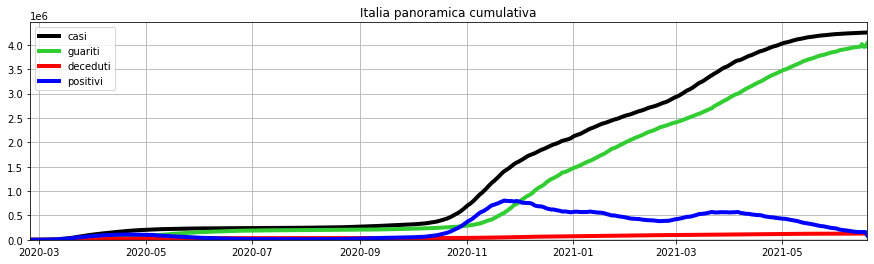

In [7]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(italy.index, filtered_italy['totale_casi'], 'k', lw=4, label='casi')
ax.plot(italy.index, filtered_italy['dimessi_guariti'], 'limegreen', lw=4, label='guariti')
ax.plot(italy.index, filtered_italy['deceduti'], 'r', lw=4, label='deceduti')
ax.plot(italy.index, filtered_italy['totale_positivi'], 'b', lw=4, label='positivi')

ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(0, smoothed_italy['totale_casi'].max()*1.05)
ax.axhline(0, c='k', alpha=.2)

ax.legend(loc='upper left')

ax.set_title("Italia panoramica cumulativa")

plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

In [8]:
filtered_italy_diff = hampel_filter_dataframe(italy.diff(), 7, 2)

smoothed_italy_diff = filtered_italy_diff.rolling(14,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=5)

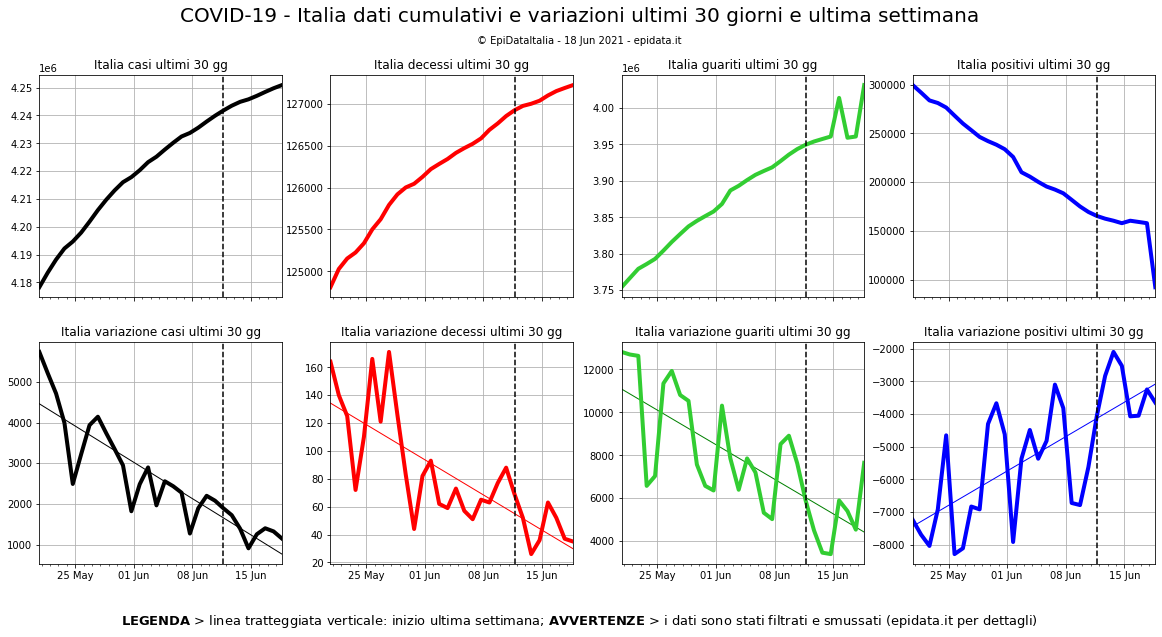

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)

ax.flat[0].plot(italy.index[-30:], filtered_italy['totale_casi'][-30:], 'k', lw=4, label='casi')
#ax.flat[0].set_ylim(smoothed_italy['totale_casi'][-30:].min(), smoothed_italy['totale_casi'][-30:].max())
ax.flat[0].grid(axis='both')
ax.flat[0].set_title("Italia casi ultimi 30 gg")
###
X = filtered_italy_diff[-30:].reset_index().index.values.reshape(-1, 1)
y = filtered_italy_diff[-30:].totale_casi.values.reshape(-1, 1)
reg_tot = LinearRegression().fit(X, y).predict(X)
ax.flat[4].plot(italy.index[-30:], reg_tot, 'k', lw=1)
ax.flat[4].plot(italy.index[-30:], filtered_italy_diff['totale_casi'][-30:], 'k', lw=4, label='casi')
#ax.flat[4].set_ylim(smoothed_italy_diff['totale_casi'][-30:].min(), smoothed_italy_diff['totale_casi'][-30:].max())
ax.flat[4].grid(axis='both')
ax.flat[4].set_title("Italia variazione casi ultimi 30 gg")

ax.flat[2].plot(italy.index[-30:], filtered_italy['dimessi_guariti'][-30:], 'limegreen', lw=4, label='guariti')
#ax.flat[2].set_ylim(smoothed_italy['dimessi_guariti'][-30:].min(), smoothed_italy['dimessi_guariti'][-30:].max())
ax.flat[2].grid(axis='both')
ax.flat[2].set_title("Italia guariti ultimi 30 gg")
###
X = filtered_italy_diff[-30:].reset_index().index.values.reshape(-1, 1)
y = filtered_italy_diff[-30:].dimessi_guariti.values.reshape(-1, 1)
reg_gua = LinearRegression().fit(X, y).predict(X)
ax.flat[6].plot(italy.index[-30:], reg_gua, 'g', lw=1)
ax.flat[6].plot(italy.index[-30:], filtered_italy_diff['dimessi_guariti'][-30:], 'limegreen', lw=4, label='guariti')
#ax.flat[6].set_ylim(smoothed_italy_diff['dimessi_guariti'][-30:].min(), smoothed_italy_diff['dimessi_guariti'][-30:].max())
ax.flat[6].grid(axis='both')
ax.flat[6].set_title("Italia variazione guariti ultimi 30 gg")

ax.flat[1].plot(italy.index[-30:], filtered_italy['deceduti'][-30:], 'r', lw=4, label='deceduti')
#ax.flat[1].set_ylim(smoothed_italy['deceduti'][-30:].min(), smoothed_italy['deceduti'][-30:].max())
ax.flat[1].grid(axis='both')
ax.flat[1].set_title("Italia decessi ultimi 30 gg")
###
X = filtered_italy_diff[-30:].reset_index().index.values.reshape(-1, 1)
y = filtered_italy_diff[-30:].deceduti.values.reshape(-1, 1)
reg_dec = LinearRegression().fit(X, y).predict(X)
ax.flat[5].plot(italy.index[-30:], reg_dec, 'r', lw=1)
ax.flat[5].plot(italy.index[-30:], filtered_italy_diff['deceduti'][-30:], 'r', lw=4, label='deceduti')
#ax.flat[5].set_ylim(smoothed_italy_diff['deceduti'][-30:].min(), smoothed_italy_diff['deceduti'][-30:].max())
ax.flat[5].grid(axis='both')
ax.flat[5].set_title("Italia variazione decessi ultimi 30 gg")

ax.flat[3].plot(italy.index[-30:], filtered_italy['totale_positivi'][-30:], 'b', lw=4, label='positivi')
#ax.flat[3].set_ylim(smoothed_italy['totale_positivi'][-30:].min(), smoothed_italy['totale_positivi'][-30:].max())
ax.flat[3].grid(axis='both')
ax.flat[3].set_title("Italia positivi ultimi 30 gg")
###
X = filtered_italy_diff[-30:].reset_index().index.values.reshape(-1, 1)
y = filtered_italy_diff[-30:].totale_positivi.values.reshape(-1, 1)
reg_pos = LinearRegression().fit(X, y).predict(X)
ax.flat[7].plot(italy.index[-30:], reg_pos, 'b', lw=1)
ax.flat[7].plot(italy.index[-30:], filtered_italy_diff['totale_positivi'][-30:], 'b', lw=4, label='positivi')
#ax.flat[7].set_ylim(smoothed_italy_diff['totale_positivi'][-30:].min(), smoothed_italy_diff['totale_positivi'][-30:].max())
ax.flat[7].grid(axis='both')
ax.flat[7].set_title("Italia variazione positivi ultimi 30 gg")

for i in np.arange(0, 8):
    ax.flat[i].axvline(italy.index[-8], color='k', ls="--")

ax.flat[0].set_xlim(italy.index[-30], italy.index[-1])
ax.flat[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax.flat[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.flat[0].xaxis.set_minor_locator(mdates.DayLocator())

fig.suptitle("COVID-19 - Italia dati cumulativi e variazioni ultimi 30 giorni e ultima settimana", y=0.985, fontsize=20)
fig.text(0.5, 0.94, f"© EpiDataItalia - {dt.datetime.now().strftime('%d %b %Y')} - epidata.it", ha="center", va="top")

fig.text(0.5, 0.05, r"$\mathbf{LEGENDA}$ > linea tratteggiata verticale: inizio ultima settimana; $\mathbf{AVVERTENZE}$ > i dati sono stati filtrati e smussati (epidata.it per dettagli)",
    fontsize=13, ha="center", va="top")

fig.set_facecolor('w')

plt.show();

# Regioni

***

Legenda:

- Panoramica
    - Rosso: deceduti
    - Verde: guariti
    - Blu: positivi

In [10]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
                     #usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
                     parse_dates=['data'],
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()

days = states.index.get_level_values('data').unique()
regions = states.index.get_level_values('denominazione_regione').unique().sort_values()

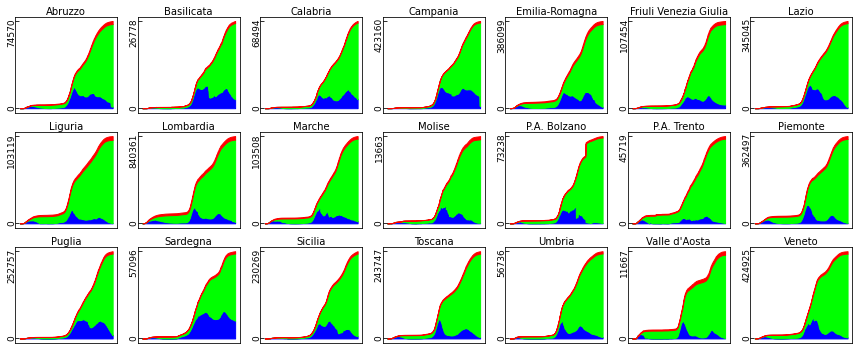

In [11]:
fig, ax = plt.subplots(3, 7, figsize=(15,6))

for i, state in enumerate(states.index.get_level_values('denominazione_regione').unique()):
    f = states.loc[state]
    I = f['totale_positivi']
    R = f['dimessi_guariti']
    D = f['deceduti']
    ax.flat[i].set_title(state, fontsize=10, pad=0)
    ax.flat[i].fill_between(
        days,
        0, I, color="b"
    )
    ax.flat[i].fill_between(
        days,
        I, R+I, color="#00ff00"
    )
    ax.flat[i].fill_between(
        days,
        R+I, R+I+D, color="r"
    )
    ax.flat[i].set_xticks([])
    ax.flat[i].set_yticks([0, (R+I+D).max()])
    ax.flat[i].tick_params(direction='in', labelsize=9, rotation=90, pad=-1)

fig.set_facecolor('w')
plt.show();

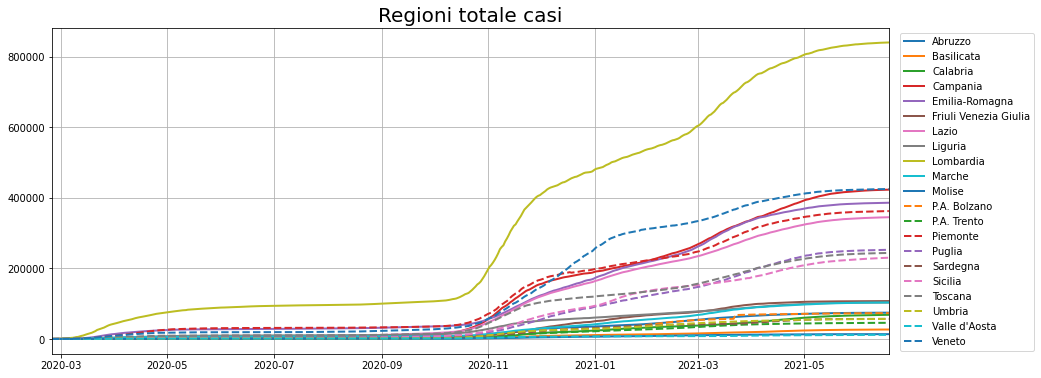

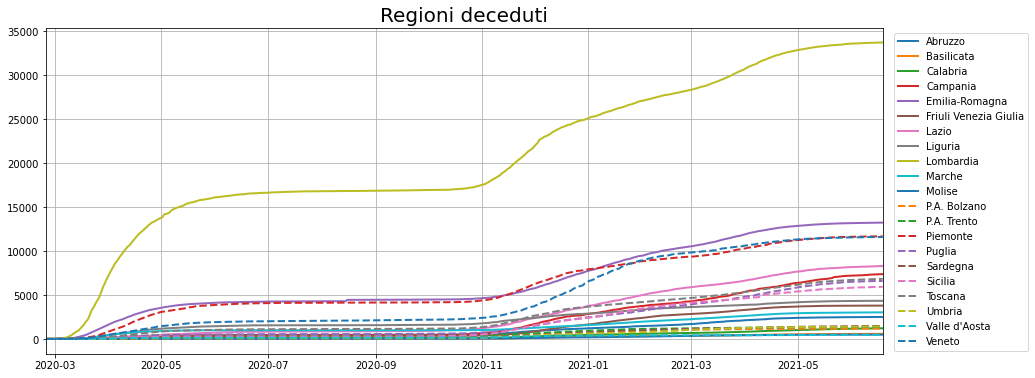

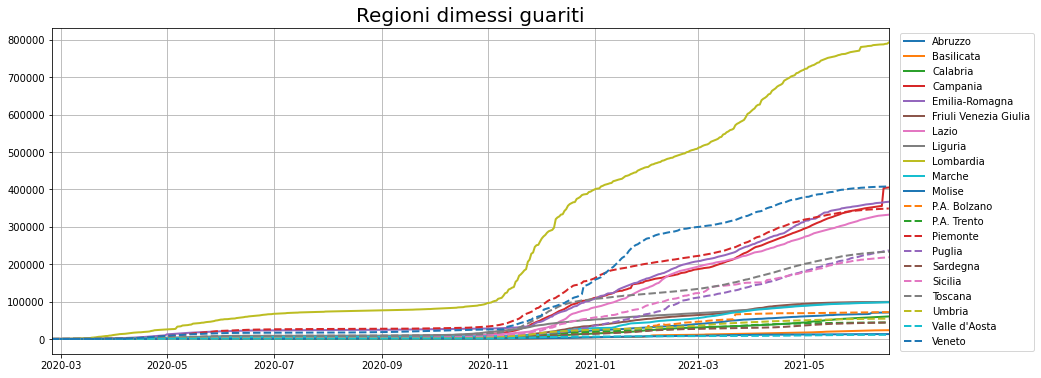

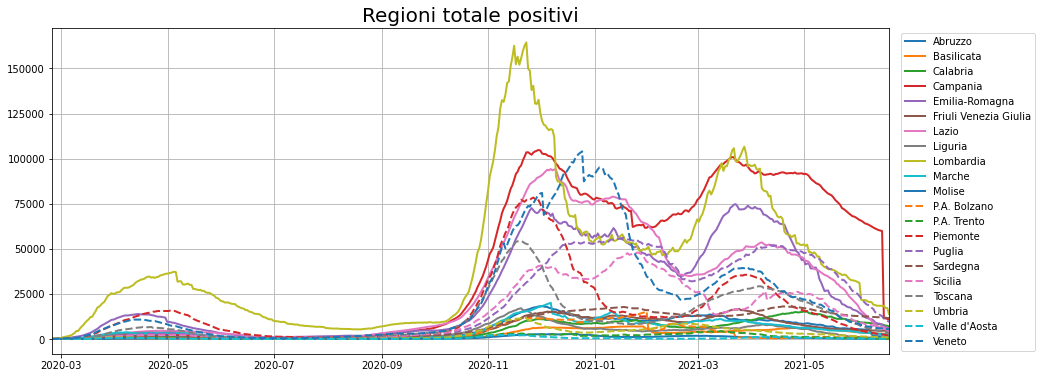

In [12]:
for col in ['totale_casi', 'deceduti', 'dimessi_guariti', 'totale_positivi']:

    fig, ax = plt.subplots(figsize=(15, 6))

    for i, region in enumerate(regions):
        ls = "--" if i > 10 else "-"
        ax.plot(days, states.loc[region][col], label=region, lw=2, ls=ls)

    ax.set_xlim(days[0], days[-1])
    ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1))
    ax.grid()

    ax.set_title(f"Regioni {col.replace('_', ' ')}", fontsize=20)
    fig.set_facecolor('w'); plt.show();

## Abruzzo

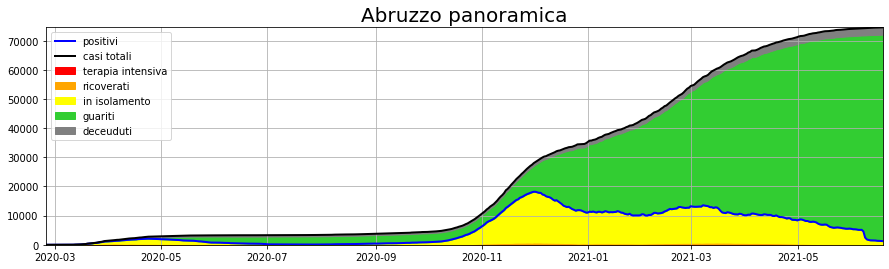

## Basilicata

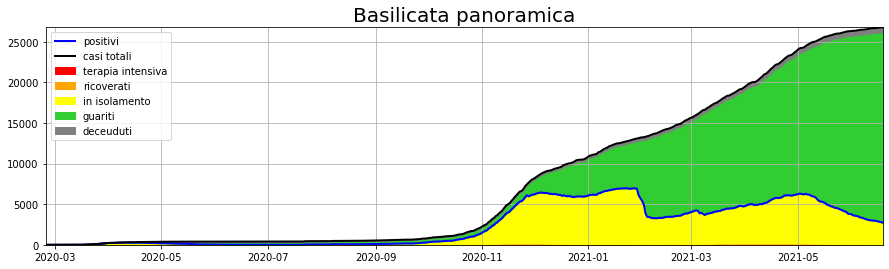

## Calabria

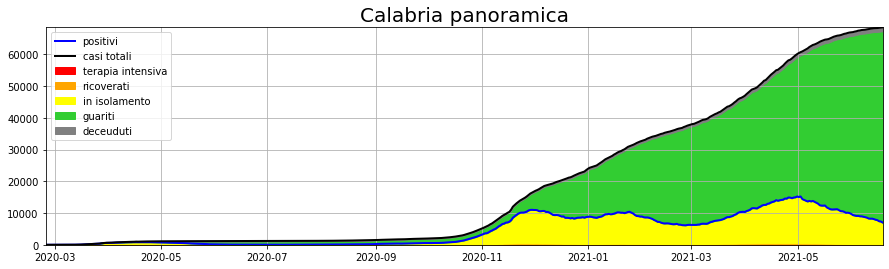

## Campania

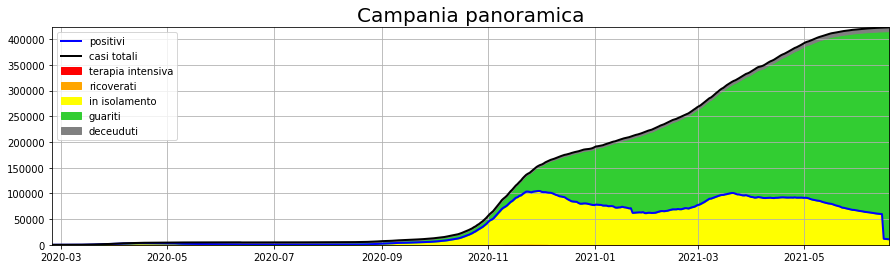

## Emilia-Romagna

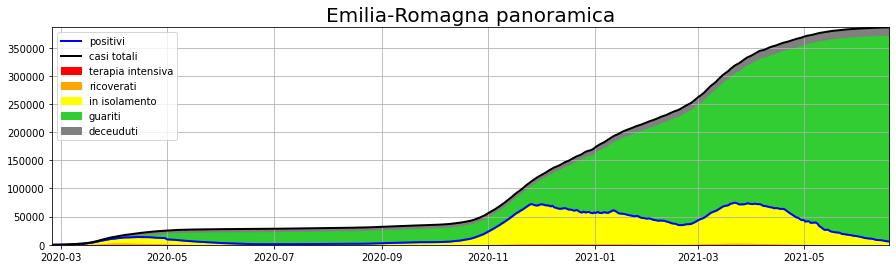

## Friuli Venezia Giulia

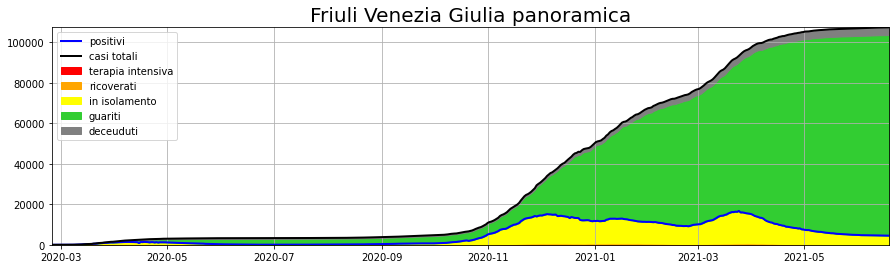

## Lazio

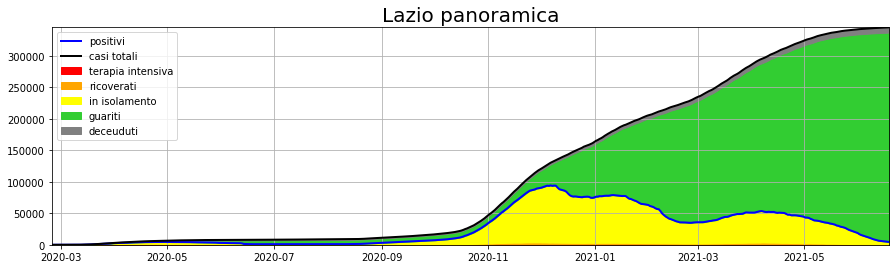

## Liguria

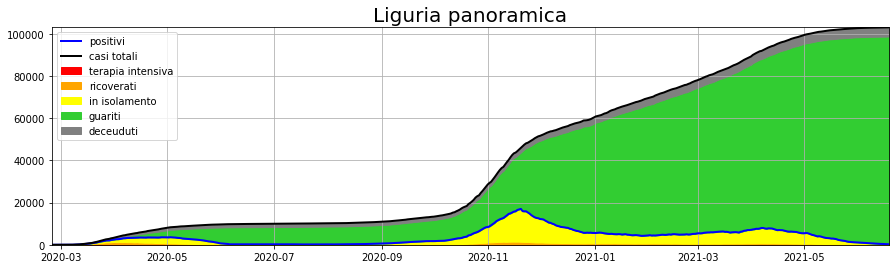

## Lombardia

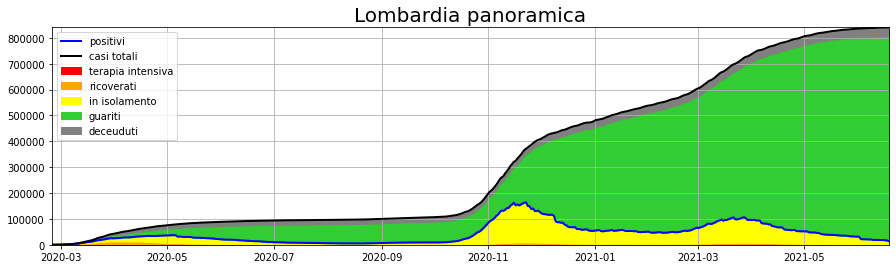

## Marche

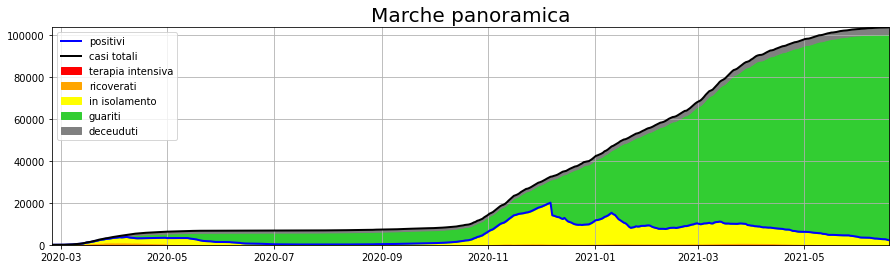

## Molise

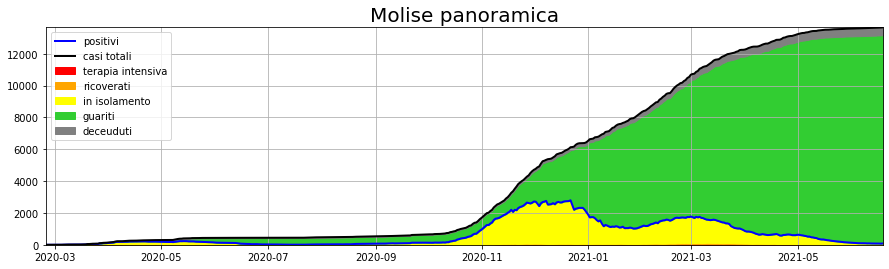

## P.A. Bolzano

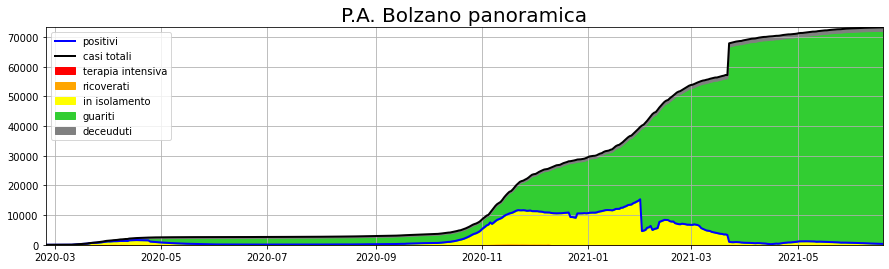

## P.A. Trento

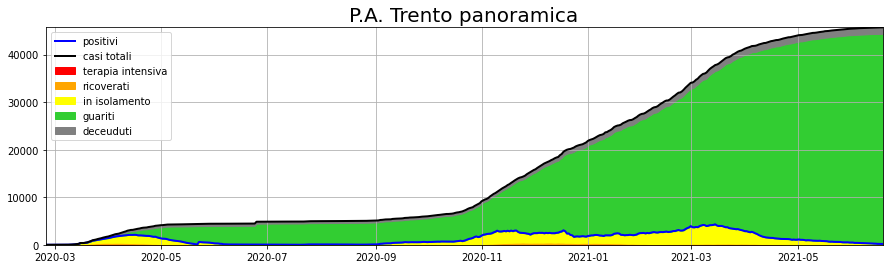

## Piemonte

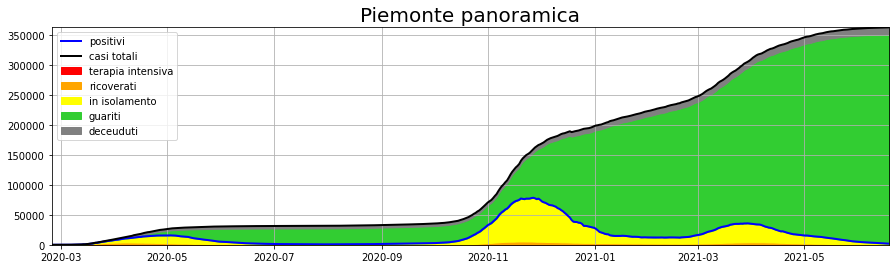

## Puglia

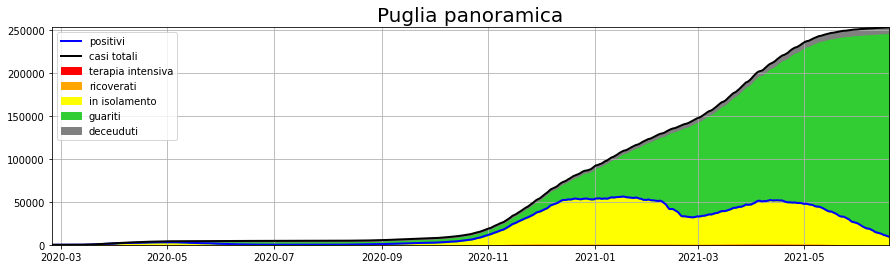

## Sardegna

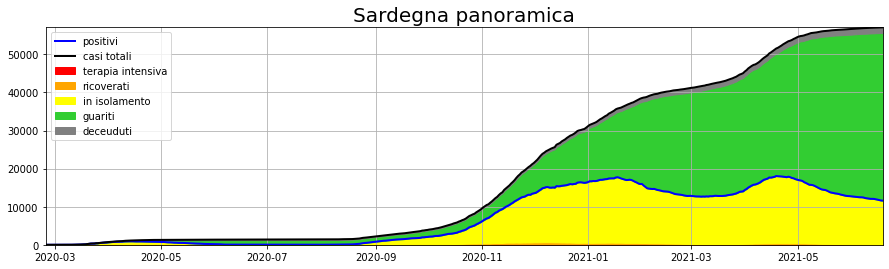

## Sicilia

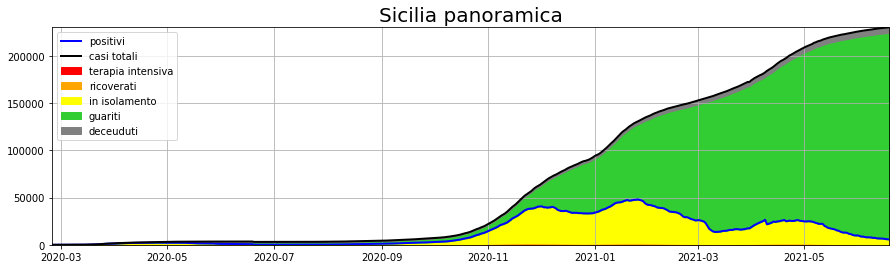

## Toscana

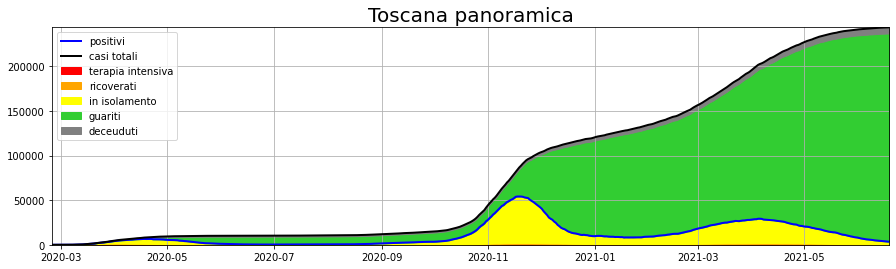

## Umbria

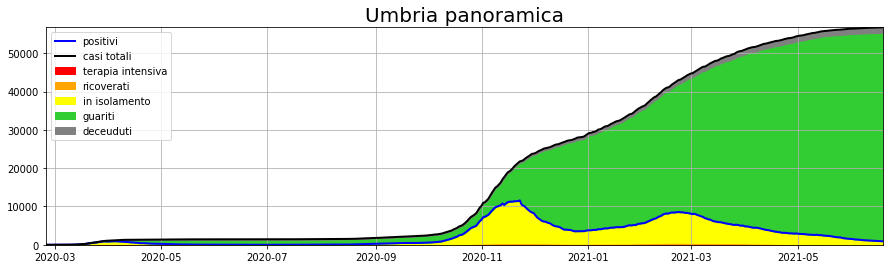

## Valle d'Aosta

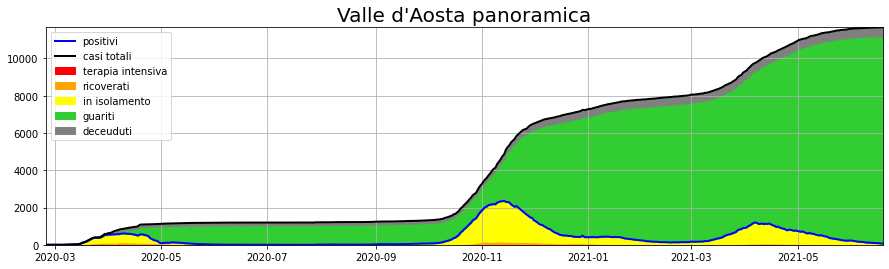

## Veneto

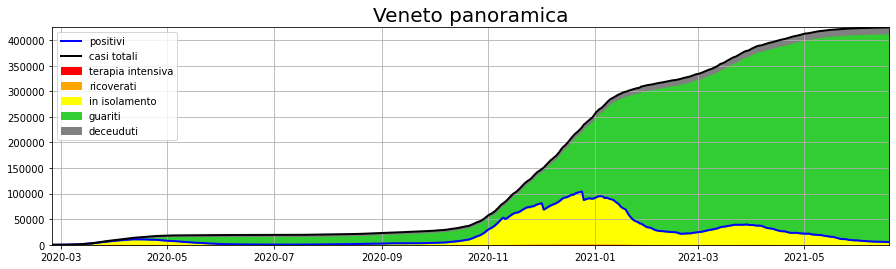

In [13]:
for region in regions:
    display(Markdown(f"## {region}"))
    fig, ax = plt.subplots(figsize=(15, 4))

    lo = 0
    hi = states.loc[region]['terapia_intensiva']
    ax.fill_between(days, lo, hi, color='red', label='terapia intensiva')

    lo = states.loc[region]['terapia_intensiva']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi']
    ax.fill_between(days, lo, hi, color='orange', label='ricoverati')

    lo = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare']
    ax.fill_between(days, lo, hi, color='yellow', label='in isolamento')

    ax.plot(days, hi, 'b', label='positivi', lw=2)

    lo = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare'] + states.loc[region]['dimessi_guariti']
    ax.fill_between(days, lo, hi, color='limegreen', label='guariti')

    lo = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare'] + states.loc[region]['dimessi_guariti']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare'] + states.loc[region]['dimessi_guariti'] + states.loc[region]['deceduti']
    ax.fill_between(days, lo, hi, color='grey', label='deceuduti')

    ax.plot(days, hi, 'k', label='casi totali', lw=2)

    ax.set_xlim(days[0], days[-1])
    ax.set_ylim(0, hi.max())

    ax.set_title(f'{region} panoramica', fontsize=20)
    ax.grid()
    
    plt.legend(loc='upper left')
    plt.show()
    plt.close(fig='all')
    
    

***

# Letalità e Guarigione

!!! ATTENZIONE !!!

Il tasso di letalità è utile nel modello epidemiologico **SIRD** ([leggi qui per dettagli](https://maxpierini.it/R0.pdf)) e definisce la percentuale di decessi sul totale dei casi, ma non è il tasso di mortalità per COVID-19 sull'intera popolazione.

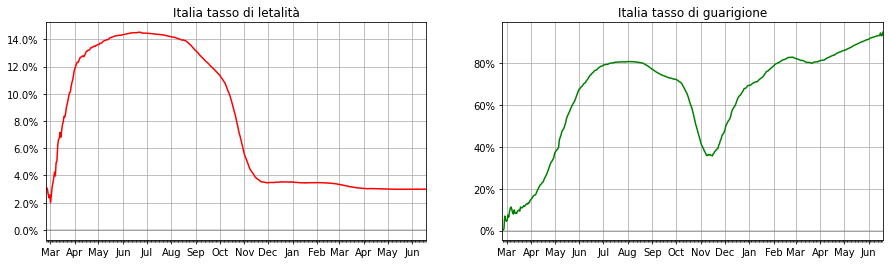

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax[0].plot(italy.index, filtered_italy['deceduti']/filtered_italy['totale_casi'], 'r', label='letalità')
ax[1].plot(italy.index, filtered_italy['dimessi_guariti']/filtered_italy['totale_casi'], 'g', label='guarigione')

ax[0].set_xlim(italy.index[0], italy.index[-1])

ax[0].axhline(0, c='k', alpha=.2)
ax[1].axhline(0, c='k', alpha=.2)

ax[0].set_title("Italia tasso di letalità")
ax[1].set_title("Italia tasso di guarigione")

#ax[0].legend(loc='upper left')
#ax[1].legend(loc='upper left')

ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

ax[0].grid(axis='both')
ax[1].grid(axis='both')

fig.set_facecolor('w'); plt.show();

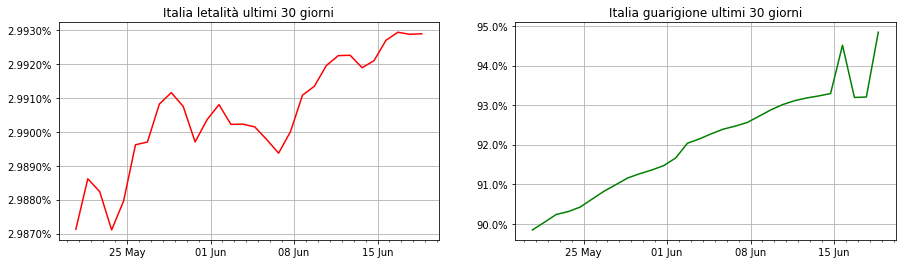

In [15]:
last = -30

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(
    italy.index[last:], 
    (filtered_italy['deceduti']/filtered_italy['totale_casi'])[last:], 
    'r', label='letalità')
ax[0].grid(axis='both')
ax[0].set_title("Italia letalità ultimi 30 giorni")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax[1].plot(
    italy.index[last:], 
    (filtered_italy['dimessi_guariti']/filtered_italy['totale_casi'])[last:], 
    'g', label='guarigione')
ax[1].grid(axis='both')
ax[1].set_title("Italia guarigione ultimi 30 giorni")
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax[1].xaxis.set_minor_locator(mdates.DayLocator())

fig.set_facecolor('w'); plt.show();

***

# Ospedalizzazione e Isolamento

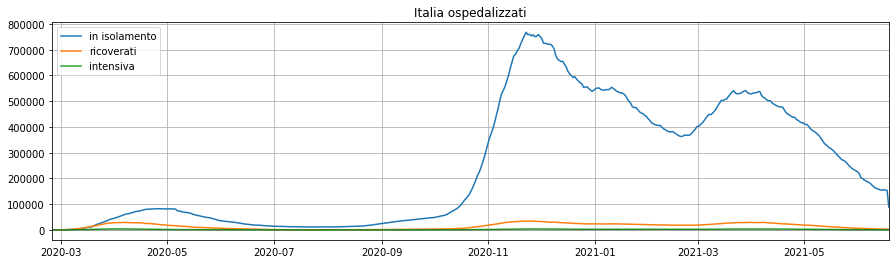

In [16]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(italy.index, filtered_italy['isolamento_domiciliare'], label='in isolamento')
ax.plot(italy.index, filtered_italy['ricoverati_con_sintomi'], label='ricoverati')
ax.plot(italy.index, filtered_italy['terapia_intensiva'], label='intensiva')

ax.set_xlim(italy.index[0], italy.index[-1])

ax.axhline(0, c='k', alpha=.2)

ax.set_title("Italia ospedalizzati")
ax.legend(loc='upper left')

plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

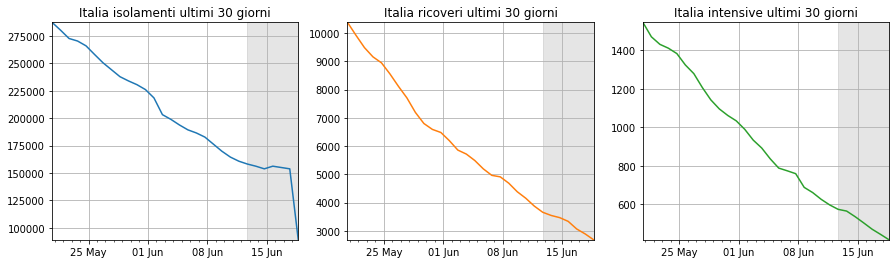

In [17]:
last = -30

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].plot(
    italy.index[last:], 
    filtered_italy['isolamento_domiciliare'][last:], 
    'C0', label='letalità')
ax[0].grid(axis='both')
ax[0].set_title("Italia isolamenti ultimi 30 giorni")

ax[1].plot(
    italy.index[last:], 
    filtered_italy['ricoverati_con_sintomi'][last:], 
    'C1', label='guarigione')
ax[1].grid(axis='both')
ax[1].set_title("Italia ricoveri ultimi 30 giorni")

ax[2].plot(
    italy.index[last:], 
    filtered_italy['terapia_intensiva'][last:], 
    'C2', label='guarigione')
ax[2].grid(axis='both')
ax[2].set_title("Italia intensive ultimi 30 giorni")

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax[1].xaxis.set_minor_locator(mdates.DayLocator())

ax[2].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax[2].xaxis.set_minor_locator(mdates.DayLocator())

for i, w in enumerate(['isolamento_domiciliare', 'ricoverati_con_sintomi', 'terapia_intensiva']):
    ax[i].fill_between(italy.index[-7:], 
                       filtered_italy[w][last:].min(), 
                       filtered_italy[w][last:].max(), 
                       color='k', alpha=.1)
    ax[i].set_ylim(filtered_italy[w][last:].min(), filtered_italy[w][last:].max())
    ax[i].set_xlim(italy.index[last], italy.index[-1])

fig.set_facecolor('w'); plt.show();

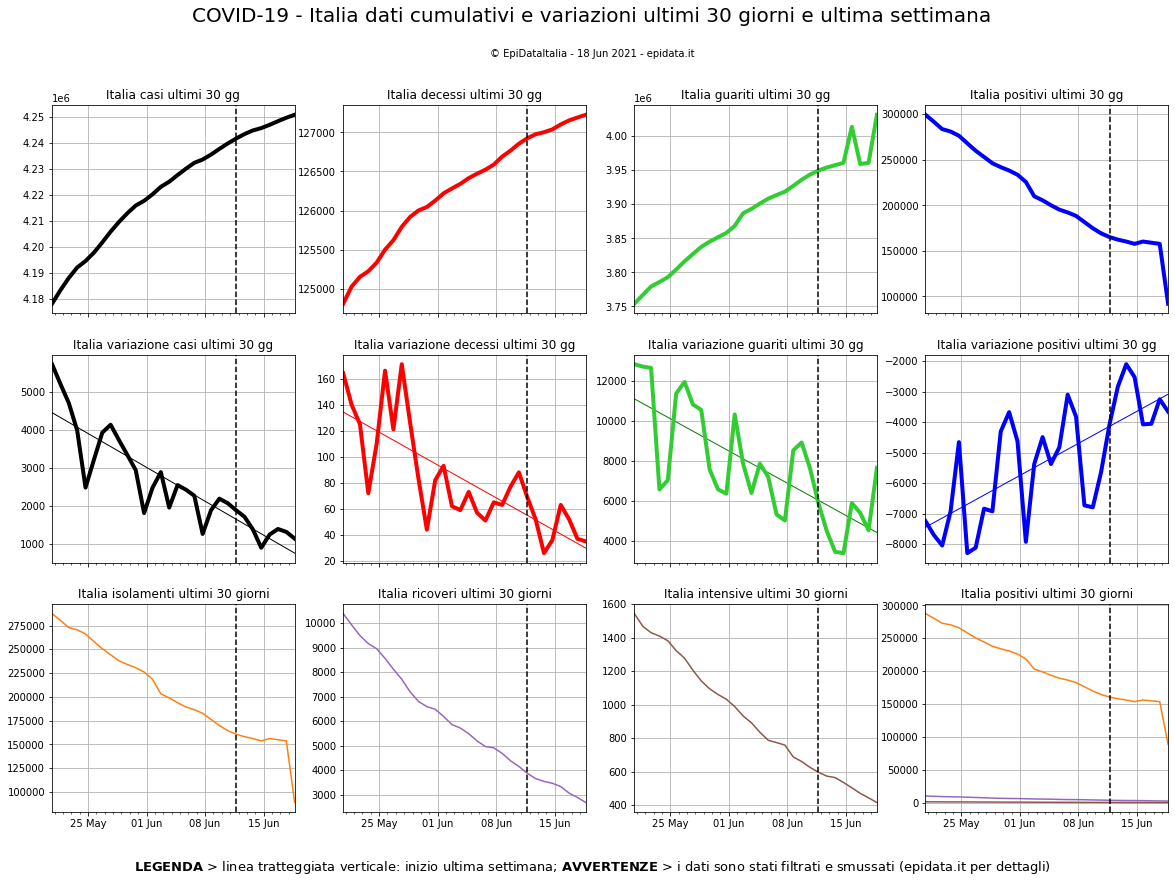

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(20, 13), sharex=True)

ax.flat[0].plot(italy.index[-30:], filtered_italy['totale_casi'][-30:], 'k', lw=4, label='casi')
#ax.flat[0].set_ylim(smoothed_italy['totale_casi'][-30:].min(), smoothed_italy['totale_casi'][-30:].max())
ax.flat[0].grid(axis='both')
ax.flat[0].set_title("Italia casi ultimi 30 gg")
###
ax.flat[4].plot(italy.index[-30:], reg_tot, 'k', lw=1)
ax.flat[4].plot(italy.index[-30:], filtered_italy_diff['totale_casi'][-30:], 'k', lw=4, label='casi')
#ax.flat[4].set_ylim(smoothed_italy_diff['totale_casi'][-30:].min(), smoothed_italy_diff['totale_casi'][-30:].max())
ax.flat[4].grid(axis='both')
ax.flat[4].set_title("Italia variazione casi ultimi 30 gg")

ax.flat[2].plot(italy.index[-30:], filtered_italy['dimessi_guariti'][-30:], 'limegreen', lw=4, label='guariti')
#ax.flat[2].set_ylim(smoothed_italy['dimessi_guariti'][-30:].min(), smoothed_italy['dimessi_guariti'][-30:].max())
ax.flat[2].grid(axis='both')
ax.flat[2].set_title("Italia guariti ultimi 30 gg")
###
ax.flat[6].plot(italy.index[-30:], reg_gua, 'g', lw=1)
ax.flat[6].plot(italy.index[-30:], filtered_italy_diff['dimessi_guariti'][-30:], 'limegreen', lw=4, label='guariti')
#ax.flat[6].set_ylim(smoothed_italy_diff['dimessi_guariti'][-30:].min(), smoothed_italy_diff['dimessi_guariti'][-30:].max())
ax.flat[6].grid(axis='both')
ax.flat[6].set_title("Italia variazione guariti ultimi 30 gg")

ax.flat[1].plot(italy.index[-30:], filtered_italy['deceduti'][-30:], 'r', lw=4, label='deceduti')
#ax.flat[1].set_ylim(smoothed_italy['deceduti'][-30:].min(), smoothed_italy['deceduti'][-30:].max())
ax.flat[1].grid(axis='both')
ax.flat[1].set_title("Italia decessi ultimi 30 gg")
###
ax.flat[5].plot(italy.index[-30:], reg_dec, 'r', lw=1)
ax.flat[5].plot(italy.index[-30:], filtered_italy_diff['deceduti'][-30:], 'r', lw=4, label='deceduti')
#ax.flat[5].set_ylim(smoothed_italy_diff['deceduti'][-30:].min(), smoothed_italy_diff['deceduti'][-30:].max())
ax.flat[5].grid(axis='both')
ax.flat[5].set_title("Italia variazione decessi ultimi 30 gg")

ax.flat[3].plot(italy.index[-30:], filtered_italy['totale_positivi'][-30:], 'b', lw=4, label='positivi')
#ax.flat[3].set_ylim(smoothed_italy['totale_positivi'][-30:].min(), smoothed_italy['totale_positivi'][-30:].max())
ax.flat[3].grid(axis='both')
ax.flat[3].set_title("Italia positivi ultimi 30 gg")
###
ax.flat[7].plot(italy.index[-30:], reg_pos, 'b', lw=1)
ax.flat[7].plot(italy.index[-30:], filtered_italy_diff['totale_positivi'][-30:], 'b', lw=4, label='positivi')
#ax.flat[7].set_ylim(smoothed_italy_diff['totale_positivi'][-30:].min(), smoothed_italy_diff['totale_positivi'][-30:].max())
ax.flat[7].grid(axis='both')
ax.flat[7].set_title("Italia variazione positivi ultimi 30 gg")

# Ospedalizzazioni
ax.flat[8].plot(
    italy.index[-30:], 
    filtered_italy['isolamento_domiciliare'][-30:], 
    'C1', label='letalità')
ax.flat[8].grid(axis='both')
ax.flat[8].set_title("Italia isolamenti ultimi 30 giorni")

ax.flat[9].plot(
    italy.index[-30:], 
    filtered_italy['ricoverati_con_sintomi'][-30:], 
    'C4', label='guarigione')
ax.flat[9].grid(axis='both')
ax.flat[9].set_title("Italia ricoveri ultimi 30 giorni")

ax.flat[10].plot(
    italy.index[-30:], 
    filtered_italy['terapia_intensiva'][-30:], 
    'C5', label='guarigione')
ax.flat[10].grid(axis='both')
ax.flat[10].set_title("Italia intensive ultimi 30 giorni")

ax.flat[11].plot(
    italy.index[-30:],
    filtered_italy['isolamento_domiciliare'][-30:], 'C1'
)
ax.flat[11].plot(
    italy.index[-30:],
    filtered_italy['ricoverati_con_sintomi'][-30:], 'C4'
)
ax.flat[11].plot(
    italy.index[-30:],
    filtered_italy['terapia_intensiva'][-30:], 'C5'
)
ax.flat[11].grid(axis='both')
ax.flat[11].set_title("Italia positivi ultimi 30 giorni")

for i in np.arange(0, 12):
    ax.flat[i].axvline(italy.index[-8], color='k', ls="--")
    
ax.flat[0].set_xlim(italy.index[-30], italy.index[-1])
ax.flat[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax.flat[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.flat[0].xaxis.set_minor_locator(mdates.DayLocator())

fig.suptitle("COVID-19 - Italia dati cumulativi e variazioni ultimi 30 giorni e ultima settimana", y=0.985, fontsize=20)
fig.text(0.5, 0.94, f"© EpiDataItalia - {dt.datetime.now().strftime('%d %b %Y')} - epidata.it", ha="center", va="top")

fig.text(0.5, 0.075, r"$\mathbf{LEGENDA}$ > linea tratteggiata verticale: inizio ultima settimana; $\mathbf{AVVERTENZE}$ > i dati sono stati filtrati e smussati (epidata.it per dettagli)",
    fontsize=13, ha="center", va="top")
    
fig.set_facecolor('w')
fig.savefig("Dati.png")

plt.show();

***

# Mobilità

Legenda:

- Mobilità
    - Blu: tempo libero e ricreazione
    - Giallo: negozi e farmacie
    - Verde: parchi
    - Rosso: stazioni di transito
    - Viola: posti di lavoro
    - Marrone: zone di residenza

In [19]:
try:

    google = pd.read_csv(
        "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv",
        usecols=[
            "date", "country_region_code", "country_region", "sub_region_1", "sub_region_2",
            "retail_and_recreation_percent_change_from_baseline",
            "grocery_and_pharmacy_percent_change_from_baseline",
            "parks_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
            "workplaces_percent_change_from_baseline",
            "residential_percent_change_from_baseline"
        ],
        parse_dates=['date'], dtype={"sub_region_1": str, "sub_region_2": str},
        index_col=["date"]
    )
    google.to_pickle("google-mobility.pkl")
    ITALY = google.loc[google["country_region_code"] == "IT"]
    National = ITALY.loc[ITALY.fillna("NONE")["sub_region_1"] == "NONE"]
    
except Exception as err:

    print(f"ERROR reading mobility csv: {err}")

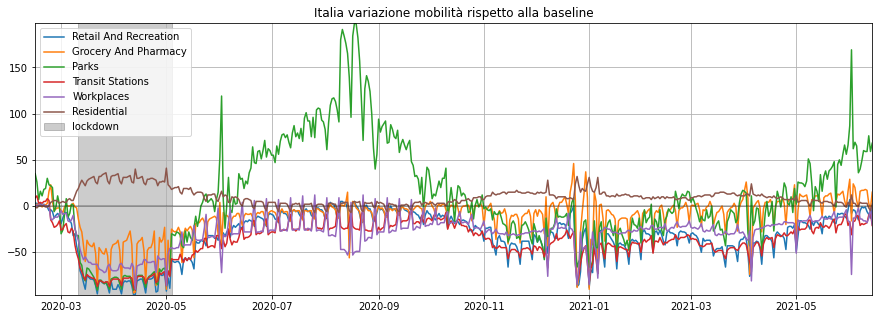

In [20]:
try:
    
    fig, ax = plt.subplots(figsize=(15, 5))

    for column in National.columns[4:]:
        ax.plot(National[column].dropna(), label=column.replace("_", " ").title().split(" Percent")[0])

    ax.axhline(0, c='k', alpha=.3)
    ax.fill_betweenx(
        [-500, 500], 
        pd.Timestamp("2020-03-11"), pd.Timestamp("2020-05-04"), 
        color='k', alpha=.2, label='lockdown'
    )

    ax.set_ylim(
        National[National.columns[4:]].dropna().values.min(),
        National[National.columns[4:]].dropna().values.max()
    )
    ax.set_xlim(National.index[0], National.index[-1])
    ax.set_title('Italia variazione mobilità rispetto alla baseline')
    ax.legend(loc='upper left')

    ax.grid()

    fig.set_facecolor('w'); plt.show();

except Exception as err:

    print(f"ERROR plotting mobility: {err}")